In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


hd_labels_dir="Labels/labels_hd"
native_labels_dir="Labels/labels_native"

# Counting total instances in HD dataset
total_hd=0
for file in os.listdir(hd_labels_dir):
    with open(os.path.join(hd_labels_dir, file), "r") as f:
        total_hd=total_hd+sum(1 for _ in f) #Counts number of lines in file

# Counting total instances in Native dataset
total_native=0
for file in os.listdir(native_label_dir):
    with open(os.path.join(native_label_dir, file), "r") as f:
        total_native += sum(1 for _ in f)#Counts number of lines in file

# Print results
print(f"Total solar panel instances in HD dataset: {total_hd}")
print(f"Total solar panel instances in Native dataset: {total_native}")
print(f"Total solar panel instances : {total_hd + total_native}")


Total solar panel instances in HD dataset: 29791
Total solar panel instances in Native dataset: 29625
Total solar panel instances : 59416


In [9]:

img_width = 416
img_height = 416

# GSD (Ground Sampling Distance) from readme
hd_gsd = 31  # cm per pixel for HD images
native_gsd = 31  # cm per pixel for native images

#Counting labels per image
def count_labels_per_image(labels_dir):
    counts = []
    for label_file in glob.glob(os.path.join(labels_dir, "*.txt")):
        with open(label_file, 'r') as f:
            instances = len(f.readlines())
            counts.append(instances)
    return Counter(counts)



In [10]:

#Calculating area statistics using GSD
def calculate_areas(labels_dir, img_width, img_height, gsd):
    areas=[]
    class_counts=Counter()
    
    for label_file in glob.glob(os.path.join(labels_dir, "*.txt")):
        with open(label_file, 'r') as f:
            for line in f:
                parts=line.strip().split()
                if len(parts) >= 5:  # Ensuring valid YOLO format
                    class_id=int(parts[0])
                    class_counts[class_id]+=1
                    
                    # YOLO format: class_id, x_center, y_center, width, height (normalized)
                    x_center,y_center = float(parts[1]),float(parts[2])
                    width,height=float(parts[3]),float(parts[4])
                    
                    # Converting normalized coordinates to pixel coordinates
                    width_px=width*img_width
                    height_px=height*img_height
                    
                    # Converting pixel dimensions to real-world dimensions in cm
                    width_cm=width_px*gsd
                    height_cm=height_px*gsd
                    
                    # Calculating area in square meters (convert from sq cm to sq m)
                    area_cm2=width_cm*height_cm
                    area_m2=area_cm2/10000  # 10000 sq cm = 1 sq m
                    
                    areas.append(area_m2)
    return np.array(areas), class_counts

In [12]:
# Function to analyze and print results for a dataset
def analyze_dataset(labels_dir, name, gsd):
    print(f"\n\n{'='*60}")
    print(f"Solar Panel Dataset Analysis - {name} Resolution ({img_width}x{img_height})")
    print(f"{'='*60}")
    print(f"GSD (Ground Sampling Distance): {gsd} cm/pixel")
    
    # 1b. Labels per image distribution
    label_counts = count_labels_per_image(labels_dir)
    total_labeled_images = sum(label_counts.values())
    print(f"\n1b. Distribution of labels per image (total images with labels: {total_labeled_images}):")

    
    # Sort the counts and display
    for count, frequency in sorted(label_counts.items()):
        print(f"    {frequency} images have {count} labels")
    
    # 2a-b. Area statistics
    areas, class_counts = calculate_areas(labels_dir, img_width, img_height, gsd)
    
    if len(areas) > 0:
        mean_area = np.mean(areas)
        std_area = np.std(areas)
        median_area = np.median(areas)
        min_area = np.min(areas)
        max_area = np.max(areas)
    
        print(f"\n2a. Area calculation method:")
        print(f"    - YOLO normalized bounding boxes converted to pixel dimensions")
        print(f"    - Pixel dimensions converted to real-world using GSD of {gsd} cm/pixel")
        print(f"    - Area calculated in square meters(converted from cm²)")
        
        print(f"\n2b. Area statistics:")
        print(f"    - Mean area: {mean_area:.2f} m²")
        print(f"    - Standard deviation: {std_area:.2f} m²")
        print(f"    - Median area: {median_area:.2f} m²")
        print(f"    - Min area: {min_area:.2f} m²")
        print(f"    - Max area: {max_area:.2f} m²")
        
        # Class distribution if multiple classes exist
        if len(class_counts) > 1:
            print("\n    Class distribution:")
            for class_id, count in sorted(class_counts.items()):
                print(f"      Class {class_id}: {count} instances")
    
        # 2c. Plot histogram of areas
        plt.figure(figsize=(10, 6))
        plt.hist(areas, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Area (m²)')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of Solar Panel Areas ({name} Resolution - {gsd} cm GSD)')
        plt.grid(axis='y', alpha=0.75)
        
        # Add mean and median lines
        plt.axvline(mean_area, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_area:.2f} m²')
        plt.axvline(median_area, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_area:.2f} m²')
        plt.legend()
        
        plt.savefig(f'solar_panel_area_histogram_{name.lower()}.png')
        
        # Display observations
        print(f"\n2c. Observations from the histogram ({name} resolution):")
        print(f"    - Histogram has been saved as 'solar_panel_area_histogram_{name.lower()}.png'")
        
        # Statistical shape description
        skewness = (mean_area - median_area) / std_area if std_area > 0 else 0
        if skewness > 0.2:
            print("    - The distribution appears right-skewed, with many smaller panels and fewer larger ones")
        elif skewness < -0.2:
            print("    - The distribution appears left-skewed, with many larger panels and fewer smaller ones")
        else:
            print("    - The distribution appears approximately symmetric")
            
        cv = std_area / mean_area if mean_area > 0 else 0  # Coefficient of variation
        if cv > 0.5:
            print("    - There is high variability in panel sizes")
        elif cv > 0.3:
            print("    - There is moderate variability in panel sizes")
        else:
            print("    - Panel sizes are relatively consistent")
            
        print("    - The typical solar panel in this dataset has an area of approximately " +
              f"{median_area:.2f} m²")
        
        return areas
    else:
        print("\nNo areas were calculated. Please check your label files and paths.")
        return np.array([])



Solar Panel Dataset Analysis - HD Resolution (416x416)
GSD (Ground Sampling Distance): 31 cm/pixel

1b. Distribution of labels per image (total images with labels: 2542):
    82 images have 1 labels
    170 images have 2 labels
    201 images have 3 labels
    229 images have 4 labels
    217 images have 5 labels
    201 images have 6 labels
    171 images have 7 labels
    164 images have 8 labels
    174 images have 9 labels
    132 images have 10 labels
    97 images have 11 labels
    73 images have 12 labels
    72 images have 13 labels
    53 images have 14 labels
    42 images have 15 labels
    37 images have 16 labels
    32 images have 17 labels
    30 images have 18 labels
    29 images have 19 labels
    13 images have 20 labels
    6 images have 21 labels
    4 images have 22 labels
    4 images have 23 labels
    4 images have 24 labels
    1 images have 25 labels
    7 images have 26 labels
    4 images have 27 labels
    4 images have 28 labels
    21 images have 29 l

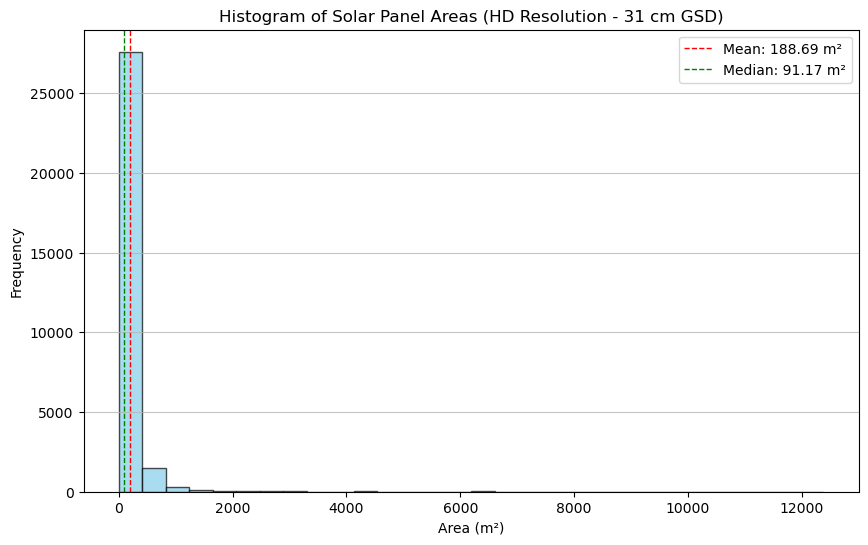

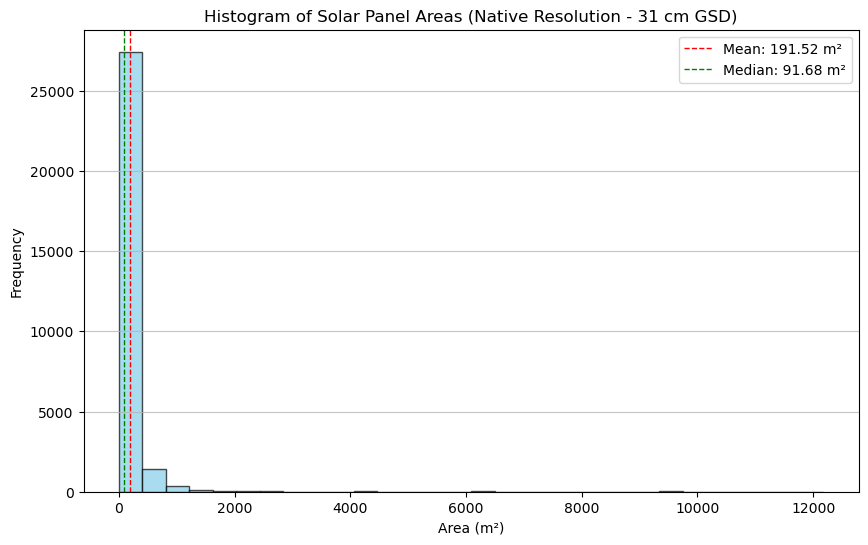

In [13]:
hd_areas = analyze_dataset(hd_labels_dir, "HD", hd_gsd)
native_areas = analyze_dataset(native_labels_dir, "Native", native_gsd)



Comparison between HD and Native datasets:
-------------------------------------------
HD mean area: 188.69 m², median: 91.17 m²
Native mean area: 191.52 m², median: 91.68 m²

Difference in mean area: -1.48%

Observation: The difference in calculated areas between datasets is relatively small.
This suggests consistent detection and measurement across different resolutions.


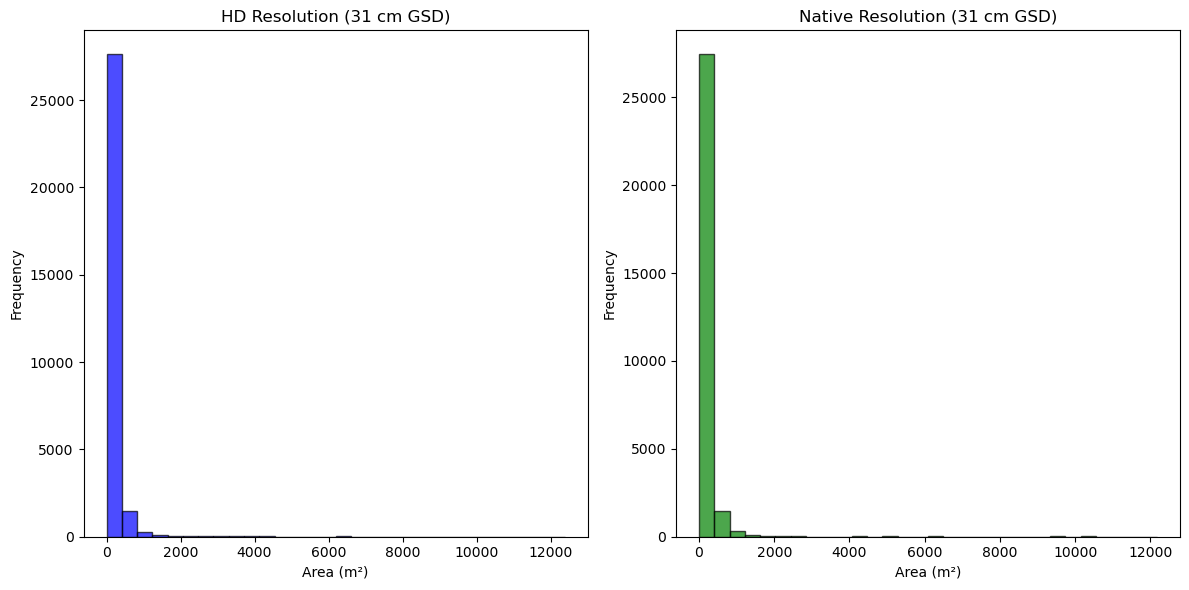

In [14]:
# Compare HD and Native if both have data
if len(hd_areas) > 0 and len(native_areas) > 0:
    plt.figure(figsize=(12, 6))
    
    # Create a side-by-side histogram
    plt.subplot(1, 2, 1)
    plt.hist(hd_areas, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Area (m²)')
    plt.ylabel('Frequency')
    plt.title('HD Resolution (31 cm GSD)')
    
    plt.subplot(1, 2, 2)
    plt.hist(native_areas, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Area (m²)')
    plt.ylabel('Frequency')
    plt.title('Native Resolution (31 cm GSD)')
    
    plt.tight_layout()
    plt.savefig('solar_panel_area_comparison.png')
    
    print("\n\nComparison between HD and Native datasets:")
    print("-------------------------------------------")
    print(f"HD mean area: {np.mean(hd_areas):.2f} m², median: {np.median(hd_areas):.2f} m²")
    print(f"Native mean area: {np.mean(native_areas):.2f} m², median: {np.median(native_areas):.2f} m²")
    
    # Calculate percent difference
    mean_diff_percent = 100 * (np.mean(hd_areas) - np.mean(native_areas)) / np.mean(native_areas)
    print(f"\nDifference in mean area: {mean_diff_percent:.2f}%")
    
    if abs(mean_diff_percent) > 10:
        print("\nObservation: There is a significant difference in calculated areas between HD and Native datasets.")
        print("This suggests that resolution impacts the precision of solar panel detection and measurement.")
    else:
        print("\nObservation: The difference in calculated areas between datasets is relatively small.")
        print("This suggests consistent detection and measurement across different resolutions.")